# Methods for effective online testing
> Testing out different bandit methods for effective online testing methods

- toc: true
- badges: true
- comments: true
- categories: [bandit]
- image: 

In [1]:
!pip install git+https://github.com/sparsh-ai/recochef.git

  Cloning https://github.com/sparsh-ai/recochef.git to /tmp/pip-req-build-1qpnc3ak
  Running command git clone -q https://github.com/sparsh-ai/recochef.git /tmp/pip-req-build-1qpnc3ak
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for recochef: filename=recochef-0.0.post1.dev7+g49ee6bc-cp37-none-any.whl size=19052 sha256=8ee4ffa07f9b2f40145e765690655b013d98cd50fb0c039a062e00207c28032b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvyexl4d/wheels/4c/90/0f/19e93713ae38e283b3ea7281df324a99bd704095da42261514
Successfully built recochef


In [2]:
import math
from typing import List

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

from recochef.models.epsilon import EpsilonGreedyRunner
from recochef.models.thompson import ThompsonSamplingRunner

In [3]:
class SplitTestRunner:
    """
    Class that is used to run simulations of split tests.

    Attributes:
        bandit_returns: List of average returns per bandit.
        batch_size: Number of examples per batch.
        batches: Number of batches.
        simulations: Number of simulations.
    
    Methods:
        init_bandits: Prepares everything for new simulation.
        run: Runs the simulations and tracks performance.
    """

    def __init__(self, bandit_returns: List[float], batch_size: int=1000, batches: int=10, simulations: int=100):
        """
        Initializes a new RunSplitTest class with passed parameters.

        Args:
            bandit_returns: List of average returns per bandit.
            batch_size: Number of examples per batch.
            batches: Number of batches.
            simulations: Number of simulations.
        """

        self.bandit_returns = bandit_returns
        self.n_bandits = len(bandit_returns)
        self.bandits = list(range(self.n_bandits))
        self.bandit_positive_examples = [0] * self.n_bandits
        self.bandit_total_examples = [0] * self.n_bandits

        self.batch_size = batch_size
        self.batches = batches
        self.simulations = simulations

        self.df_bids = pd.DataFrame(columns=self.bandit_returns)
        self.df_clicks = pd.DataFrame(columns=self.bandit_returns)
 
    def init_bandits(self):
        """
        Prepares everything for new simulation.
        """

        self.bandit_positive_examples = [0] * self.n_bandits
        self.bandit_total_examples = [0] * self.n_bandits
    
    def run(self):
        """
        Runs the simulations and tracks performance.
        """

        for j in range(self.simulations):
            self.init_bandits()
            for i in range(self.batches):
                examples = self.batch_size // self.n_bandits
                for idx in self.bandits:
                    self.bandit_total_examples[idx] += examples
                    self.bandit_positive_examples[idx] += np.random.binomial(examples, self.bandit_returns[idx])
                if self.df_bids.shape[0] < self.batches:
                    self.df_bids.loc[i] = self.bandit_total_examples
                    self.df_clicks.loc[i] = self.bandit_positive_examples
                else:
                    self.df_bids.loc[i] += self.bandit_total_examples
                    self.df_clicks.loc[i] += self.bandit_positive_examples
        self.df_bids /= self.simulations
        self.df_clicks /= self.simulations

In [4]:
def line_plot(df: pd.DataFrame, title:str, x_label: str, y_label: str):
    """
    Plots a line plot of the passed DataFrame.

    Args:
        df: DataFrame containing data to be plotted.
        title: Title of the plot.
        x_label: Title of the x-axis.
        y_label: Title of the y-axis.
    """
    stacked_data = df.apply(lambda x: x*100/sum(x), axis=1)
    stacked_data.plot(kind="line", stacked=True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)


def stacked_plot(df: pd.DataFrame, title:str, x_label: str, y_label: str):
    """
    Plots a stacked area plot of the passed DataFrame.

    Args:
        df: DataFrame containing data to be plotted.
        title: Title of the plot.
        x_label: Title of the x-axis.
        y_label: Title of the y-axis.
    """
    stacked_data = df.apply(lambda x: x*100/sum(x), axis=1)
    stacked_data.plot(kind="area", stacked=True, figsize=(12,6))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)


def plot_line_plots(rst: SplitTestRunner, reg: EpsilonGreedyRunner, rts: ThompsonSamplingRunner):
    """
    Plots a line plots for each type of test.

    Args:
        rst: Split test simulation class.
        reg: Epsilon-greedy MAB test simulation class.
        rts: Thompson sampling test simulation class.
    """
    line_plot(rst.df_bids,
              title='A/B Test Bandit Resources Allocation',
              x_label='Batch',
              y_label='Bandit Allocation (%)')

    line_plot(reg.df_bids,
              title='Epsilon Greedy Bandit Resources Allocation',
              x_label='Batch',
              y_label='Bandit Allocation (%)')

    line_plot(rts.df_bids,
              title='Thompson Sampling Bandit Resources Allocation',
              x_label='Batch',
              y_label='Bandit Allocation (%)')


def plot_stacked_plots(rst: SplitTestRunner, reg: EpsilonGreedyRunner, rts: ThompsonSamplingRunner):
    """
    Plots a stacked area plots for each type of test.

    Args:
        rst: Split test simulation class.
        reg: Epsilon-greedy MAB test simulation class.
        rts: Thompson sampling test simulation class.
    """
    stacked_plot(rst.df_bids,
             title='A/B Test Bandit Resources Allocation',
             x_label='Batch',
             y_label='Bandit Allocation (%)')

    stacked_plot(reg.df_bids,
                title='Epsilon Greedy Bandit Resources Allocation',
                x_label='Batch',
                y_label='Bandit Allocation (%)')

    stacked_plot(rts.df_bids,
                title='Thompson Sampling Bandit Resources Allocation',
                x_label='Batch',
                y_label='Bandit Allocation (%)')


def plot_gain(rst: SplitTestRunner, reg: EpsilonGreedyRunner, rts: ThompsonSamplingRunner):
    """
    Plots the returns of each kind of test over the batches it ran.

    Args:
        rst: Split test simulation class.
        reg: Epsilon-greedy MAB test simulation class.
        rts: Thompson sampling test simulation class.
    """
    rst_gain = rst.df_clicks.sum(axis=1)
    reg_gain = reg.df_clicks.sum(axis=1)
    rts_gain = rts.df_clicks.sum(axis=1)
    df_gains = pd.concat([rst_gain, reg_gain, rts_gain], axis=1)
    df_gains.rename(columns={0: 'Split Test', 1: 'Epsilon Greedy MAB', 2: 'Thompson Sampling'}, inplace=True)
    df_gains.plot(figsize=(12,6))

In [9]:
def z_calc(p1: float, p2: float, n1: int, n2: int) -> float:
    """
    Calculates the z value for the difference of two sample means.

    Args:
        p1: Mean of first sample.
        p2: Mean of second sample.
        n1: Sample size of the first sample.
        n2: Sample size of the second sample.
    Returns:
        The calculated z value.
    """
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))


def sample_required(p1: float, p2: float, alpha: float=0.01) -> int:
    """
    Calculates the sample size needed to provide a test power of (1-alpha)
    in which we are testing h0: p2-p1==0.

    Args:
        p1: Mean of first sample.
        p2: Mean of second sample.
        alpha: Type one error.
    Returns:
        The calculated sample size.
    """
    n = 1
    while True:
        z = z_calc(p1, p2, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n


def closest_pair(bandits: List[float]) -> (float, float):
    """
    Finds the two bandits that have the closest average return
    and returns their returns.

    Args:
        bandits: list of average bandit returns.
    Returns:
        The average return of the two bandits that are the most
        similar.
    """
    bandits.sort()
    min_diff = float("inf")
    p1 = -1
    p2 = -1
    for i in range(len(bandits)-1):
        if bandits[i+1] - bandits[i] < min_diff:
            p1 = bandits[i]
            p2 = bandits[i+1]
            min_diff = p2 - p1
    return p1, p2


def get_minimum_sample(bandits: List[float], alpha: float=0.01) -> int:
    """
    Gets the minimum sample size required to provide a test power of
    (1-alpha/len(bandits)), this includes the p-value Bonferroni correction.

    Args:
        bandits: list of average bandit returns.
        alpha: Type one error.
    Returns:
        Needed sample size.
    """
    p1, p2 = closest_pair(bandits)
    return sample_required(p1, p2, alpha/len(bandits))


def get_number_batches(examples_needed: int, batch_size: int) -> int:
    """
    Gets the number of batches based on the number of needed examples
    and provided batch size.

    Args:
        examples_needed: Total number of examples needed.
        batch_size: Number of examples per batch.
    Returns:
        The number of batches.
    """
    return math.ceil(examples_needed / batch_size)


def simulate(bandits: List[float], alpha: float=0.001, batch_size: int=5000, simulations: int=1000, epsilon: float=0.1, sample_size: int=1000) -> (SplitTestRunner, EpsilonGreedyRunner, ThompsonSamplingRunner):
    """
    Runs simulations for split tests, Epsilon-greedy multi-armed bandits
    and Thompson sampling based on the provided parameters.

    Args:
        bandits: list of average bandit returns.
        alpha: Type one error.
        batch_size: Number of examples per batch.
        simulations: Number of simaltions per test type.
        epsilon: percentage of exploration in epsilon-greedy MAB
        sample_size: sample size per bandit for each Thompson sampling batch
    Returns:
        The classes for each type of test.
    """
    examples_needed = get_minimum_sample(bandits, alpha)
    batches = get_number_batches(examples_needed, batch_size)

    rst = SplitTestRunner(bandits,
                          batch_size=batch_size,
                          batches=batches,
                          simulations=simulations)

    reg = EpsilonGreedyRunner(bandits,
                              epsilon=epsilon, 
                              batch_size=batch_size,
                              batches=batches,
                              simulations=simulations)

    rts = ThompsonSamplingRunner(bandits,
                                 alpha_priors=None,
                                 beta_priors=None,
                                 sample_size=sample_size,
                                 batch_size=batch_size,
                                 batches=batches,
                                 simulations=simulations)

    rst.run()
    reg.run()
    rts.run()
    return rst, reg, rts


def run_simulations(bandits: List[float], alpha: float=0.001, batch_size: int=1000,
                    simulations: int=1000, epsilon: float=0.1, sample_size: int=1000):
    """
    Starts the simulation process, gets the results and makes plots.

    Args:
        bandits: list of average bandit returns.
        alpha: Type one error.
        batch_size: Number of examples per batch.
        simulations: Number of simaltions per test type.
        epsilon: percentage of exploration in epsilon-greedy MAB
        sample_size: sample size per bandit for each Thompson sampling batch
    """
    rst, reg, rts = simulate(bandits=bandits,
                             alpha=alpha,
                             batch_size=batch_size,
                             simulations=simulations,
                             epsilon=epsilon,
                             sample_size=sample_size)

    plot_stacked_plots(rst=rst,
                       reg=reg,
                       rts=rts)

    plot_gain(rst=rst,
              reg=reg,
              rts=rts)


def simulate_ts(bandits: List[float], alpha_priors: List[float], beta_priors: List[float], batch_size: int=5000, simulations: int=1000, sample_size: int=1000):
    batches = 700

    rts = ThompsonSamplingRunner(bandits,
                              alpha_priors=None,
                              beta_priors=None,
                              sample_size=sample_size,
                              batch_size=batch_size,
                              batches=batches,
                              simulations=simulations)
    
    rts.run()
    
    stacked_plot(rts.df_bids,
                 title='Thompson Sampling Resources Allocation',
                 x_label='Batch',
                 y_label='Bandit Allocation (%)')
    return rts.df_bids, rts.df_clicks

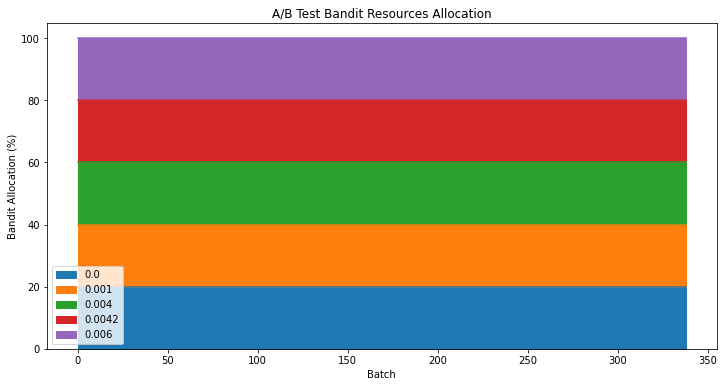

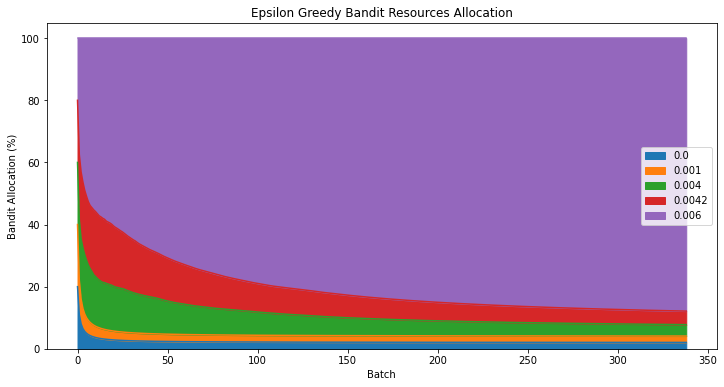

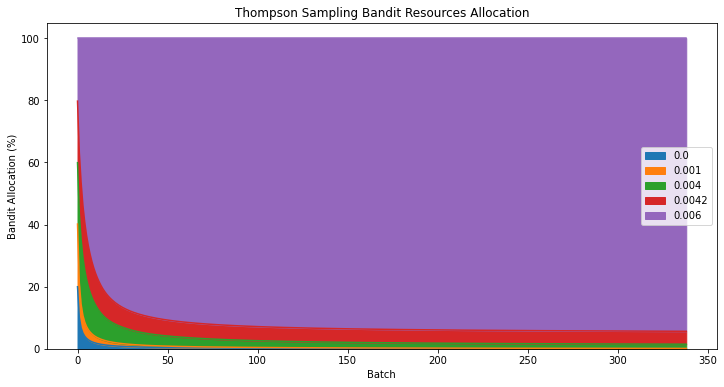

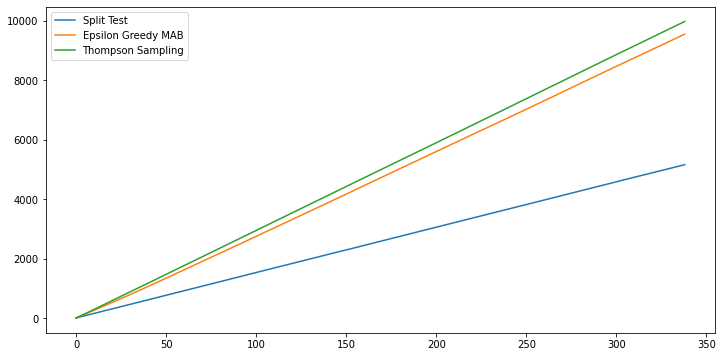

In [6]:
bandit_returns = [.001, .004, .0042, 0, 0.006]
alpha = 0.01
batch_size = 5000
simulations = 100
epsilon = 0.1
sample_size = 1000

run_simulations(bandits=bandit_returns,
                alpha=alpha,
                batch_size=batch_size,
                simulations=simulations,
                epsilon=epsilon,
                sample_size=sample_size)

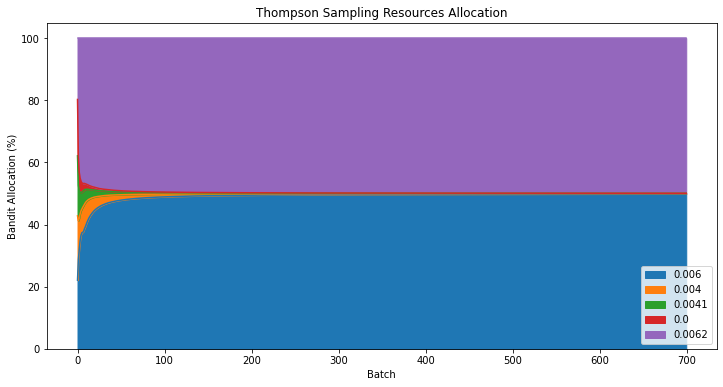

In [10]:
bandit_returns = [.006, .004, .0041, 0, 0.0062]
alpha_priors = [1., 1., 1., 1., 1.]
beta_priors = [1., 1., 1., 1., 1.]
batch_size = 5000
simulations = 2
sample_size = 1000

b, c = simulate_ts(bandits=bandit_returns,
                alpha_priors=alpha_priors,
                beta_priors=beta_priors,
                batch_size=batch_size,
                simulations=simulations,
                sample_size=sample_size)

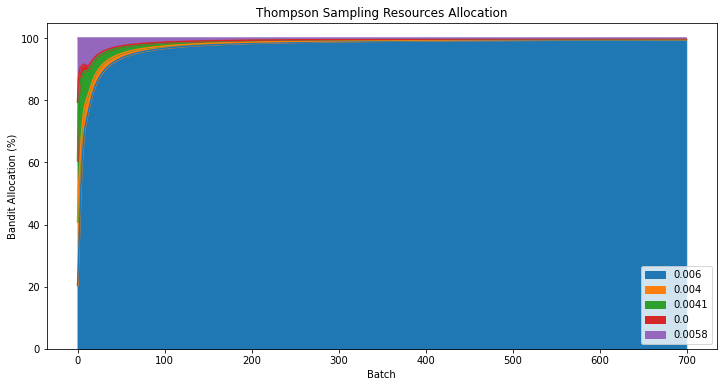

In [11]:
bandit_returns = [.006, .004, .0041, 0, 0.0058]
alpha_priors = [1., 1., 1., 1., 1.]
beta_priors = [1., 1., 1., 1., 1.]
batch_size = 5000
simulations = 2
sample_size = 1000

b, c = simulate_ts(bandits=bandit_returns,
                alpha_priors=alpha_priors,
                beta_priors=beta_priors,
                batch_size=batch_size,
                simulations=simulations,
                sample_size=sample_size)